In [2]:
"""
Author: Rainy
Date: Oct 3 2019
"""

'\nAuthor: Rainy\nDate: Oct 3 2019\n'

In [3]:
# set up
import pandas as pd
import numpy as np
from collections import defaultdict
# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# systems
import warnings
warnings.filterwarnings("ignore")
# nlp
import preprocessor as p # for preprocessing twitter data
import spacy # fav nlp
import nltk # not so fav nlp

In [5]:
# load data, takes a few minutes
files = []
for i in range(2,12):
    file_names = 'Stream ({}).xlsx'.format(i)
    files.append(file_names)

df_twitter = pd.DataFrame()
for file in files:
    df_twitter = pd.concat([df_twitter,pd.read_excel(file, sheetname = 'Stream')])

In [6]:
# non-twitter data
df_non_twitter = pd.concat([pd.read_excel('T Only 3_1_2017 thru 6_30_2017 Random Stream (1).xlsx', sheetname='Stream'),
                           pd.read_excel('T Only 9_1_2017 thru 10_31_2017 Random Stream (1).xlsx', sheetname='Stream')])


In [7]:
# store the df to pickle so that i can reaccess it without going through all the pain
df_twitter.to_pickle("df_twitter.pkl")  # where to save it, usually as a .pkl
df_non_twitter.to_pickle("df_non_twitter.pkl")  # where to save it, usually as a .pkl


In [8]:
# read from pickle
df_twitter = pd.read_pickle("df_twitter.pkl")
df_non_twitter = pd.read_pickle("df_non_twitter.pkl")


# Data inspection and data preprocessing

In [9]:
df_twitter.shape, df_non_twitter.shape

((443273, 41), (69548, 41))

In [10]:
# join twitter and non-twitter dataset together
df = pd.concat([df_twitter,df_non_twitter])

In [11]:
# drop not actionable data
df.drop(columns = ["Post ID", "URL",'Domain', 'Author URL','Author Handle','Author Location - State/Province 1', 'Author Location - State/Province 2', 'Author Location - City 2',
        'Author Location - Other','Author Location - City 1','Author Location - Country 2'], inplace = True)

In [12]:
df.shape

(512821, 30)

In [13]:
# drop columns with all information missing
for col in df.columns:
    if df[col].isnull().sum() == len(df):
        df.drop(columns = [col], inplace = True)

In [14]:
df.columns

Index(['Sound Bite Text', 'Title', 'Source Type', 'Post Type', 'Media Type',
       'Published Date (GMT-04:00) New York', 'Author Gender', 'Author Name',
       'Author ID', 'Author Location - Country 1',
       'No. of Followers/Daily Unique Visitors', 'Professions', 'Interests',
       'Positive Objects', 'Negative Objects', 'Richness', 'Quoted Post',
       'Quoted Author Name', 'Quoted Author Handle', 'Total Engagements',
       'Post Comments', 'Post Likes', 'Post Shares', 'Product Name', 'Rating'],
      dtype='object')

In [15]:
df.shape

(512821, 25)

In [16]:
# datetime conversion
df["Published Date (GMT-04:00) New York"].dtype

dtype('O')

In [17]:
# takes a few minutes
df["Published Date (GMT-04:00) New York"] = pd.to_datetime(df["Published Date (GMT-04:00) New York"])

In [21]:
df = df.rename(columns={"Author Location - Country 1" : "Country"})

In [22]:
# store this df to pickle for a less painful life
df.to_pickle("df_all.pkl")

df = pd.read_pickle("df_all.pkl")

In [23]:
df.shape

(512821, 25)

# EDA 
## Users Demography and Market Research

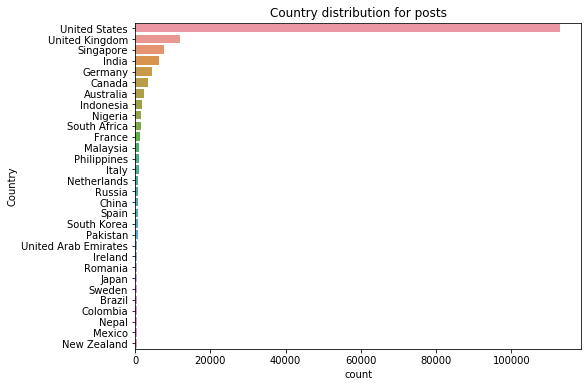

In [21]:
# where they come from
plt.figure(figsize = (8,6))
sns.countplot(y = df["Country"], order = df["Country"].value_counts().index[:30])
plt.title("Country distribution for posts")
plt.show()

A large majority of the population are from US, followed by UK, Singapore, India, Germany, and Canada, and Australia. We can further interpret the result based on the continents of different markets.

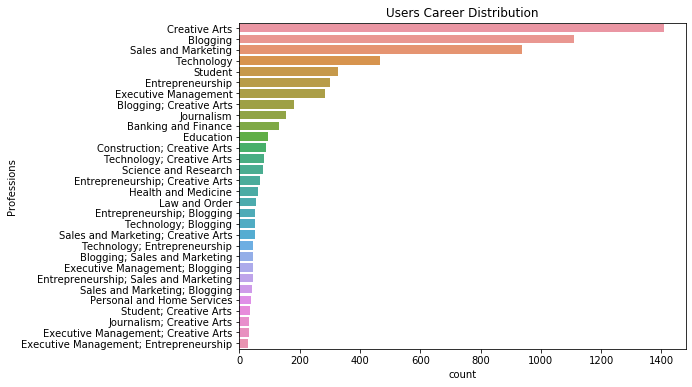

In [106]:
plt.figure(figsize = (8,6))
ax = sns.countplot(y= df["Professions"],order=df['Professions'].value_counts().index[:30])
plt.title("Users Career Distribution")
plt.show()

Most of the reviewers are in the career of creative arts, blogging, sales/marketing, technology, students, and managements. This is interesting and we can further interpret the review analysis based on the major categories of the careers, and we can even group similar careers together.

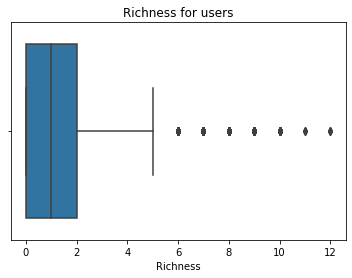

In [145]:
sns.boxplot(x = df["Richness"])
plt.title("Richness for users")
plt.show()

Apparently most users rate themselves from 0 to 4,with the max richness score around 12. Although the richness is not clear on the measurement standard, we can still assume that most users are not super duper rich, at least according to themselves, meaning that this market reserach demography has an income level that is not too obnoxious.

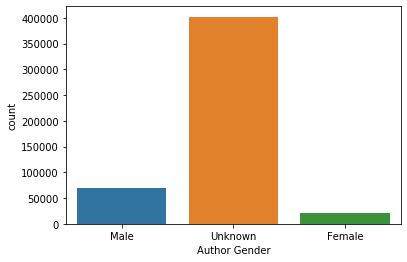

In [138]:
sns.countplot(df["Author Gender"])
plt.show()

Male reviewers are more than female, based on the information we have.

## Reivew Features Analysis

In [116]:
df.loc[:,['Source Type', 'Post Type', 'Media Type']].describe()

,Source Type,Post Type,Media Type
count,493173,493173,493173
unique,9,3,15
top,Blogs,Original,No Media
freq,172673,410270,244291


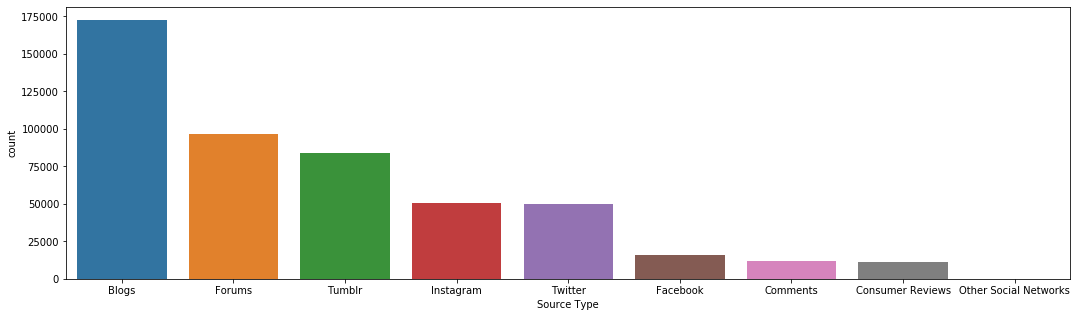

In [124]:
plt.figure(figsize = (18,5))
sns.countplot(df["Source Type"], order = df["Source Type"].value_counts().index)
plt.show()

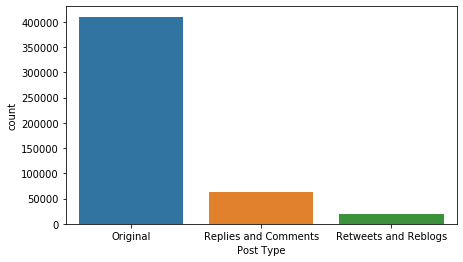

In [131]:
plt.figure(figsize = (7,4))
sns.countplot(df["Post Type"], order = df["Post Type"].value_counts().index)
plt.show()

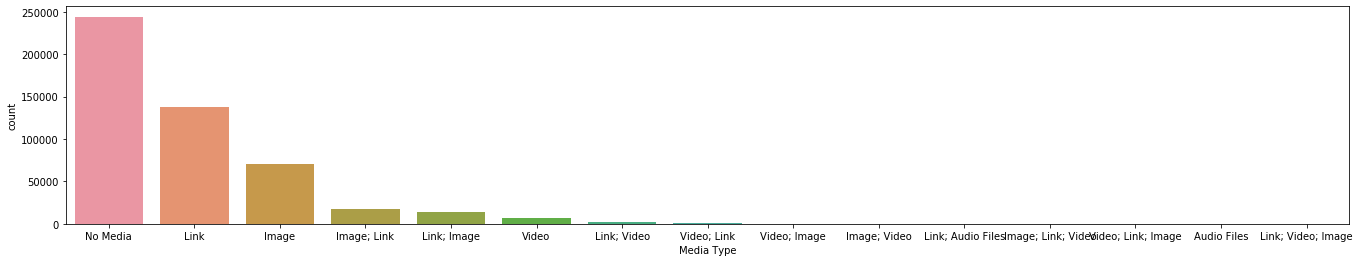

In [135]:
plt.figure(figsize = (23,4))
sns.countplot(df["Media Type"], order = df["Media Type"].value_counts().index)
plt.show()

Post sources are mostly original posts and most of the posts are from Blogs, not directly from Twitters. Other posts are mostly from Ins, Forums, and Tumblr, and most of them are in text format with no attachments nor links.

# Text Preprocessing


In [24]:
# set up 
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = spacy.load('en_core_web_sm')
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)
# spacy stop words
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [25]:
from nltk.tokenize import word_tokenize # nltk tokenizer
nltk_stopwords = nltk.corpus.stopwords.words('english') # nltk stop words
from nltk.util import ngrams

## Titles

In [26]:
title_list = list(df["Title"].dropna())

In [27]:
# lower case
title_list = [i.lower() for i in title_list]

In [28]:
# tokenize all titles
all_tokens = []
for doc in title_list:
    all_tokens.append(word_tokenize(doc))

In [29]:
# flatten list
tokens = []
for i in all_tokens:
    for j in i:
        tokens.append(j)

In [78]:
len(tokens)

2215797

In [31]:
# remove stop words
tokens = [i for i in tokens if i not in nltk_stopwords]

In [32]:
# remove punctuation
tokens = [i for i in tokens if i.isalnum()]

In [33]:
len(tokens)

2215797

In [34]:
# ngrams
bigram = list(ngrams(tokens,2))


In [35]:
# create a dict with ngram count
dct_bigram = defaultdict(int)
for tup in bigram:
    if tup not in dct_bigram:
        dct_bigram[tup] = 1
    else:
        dct_bigram[tup] += 1
    
dct_bigram = {str(k[0] + ' ' + k[1]) : v for k,v in dct_bigram.items()} # tuple to string

In [36]:
# some inspection
dct_bigram['samsung galaxy'], dct_bigram['iphone 7']

(49097, 4685)

In [38]:
len(dct_bigram)

422463

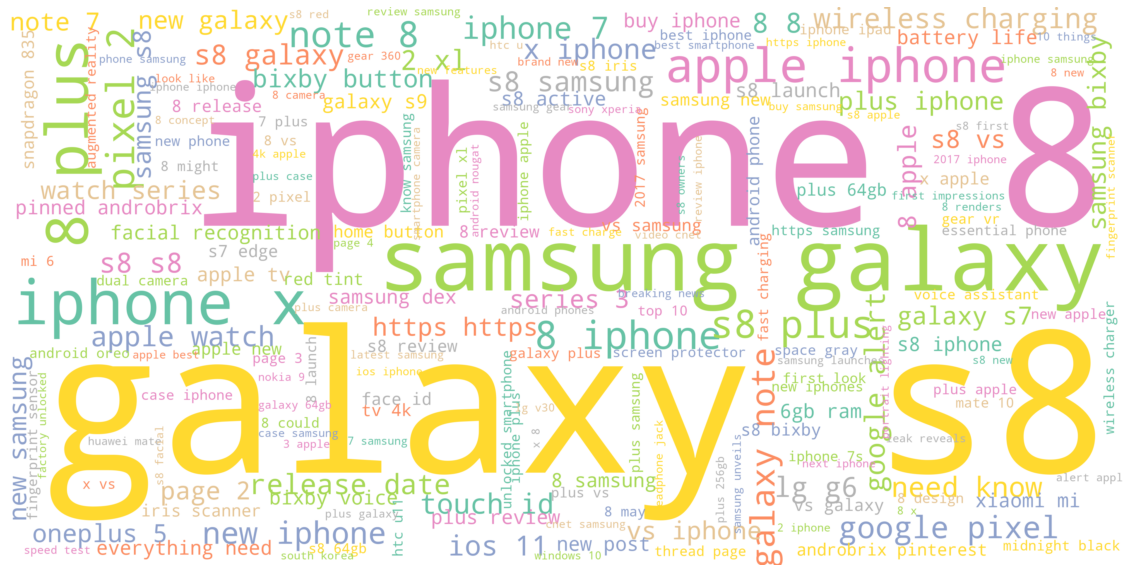

In [49]:
# visualization for titles
# Create the wordcloud object
wordcloud = WordCloud(width = 400, height = 200,margin = 0,
                      background_color = 'white', colormap = 'Set2',max_words=200000, scale = 10).generate_from_frequencies(dct_bigram)
plt.figure(figsize = (20,40))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_title_bigram.png")
plt.show()


In [91]:
# another visualization without product names
dct_bigram_clean = {k : v for k, v in dct_bigram.items() 
                    if "galaxy" not in k and "samsung" not in k and "iphone" not in k
                   and "s8" not in k and "note" not in k and "plus" not in k}

In [92]:
len(dct_bigram_clean)

386698

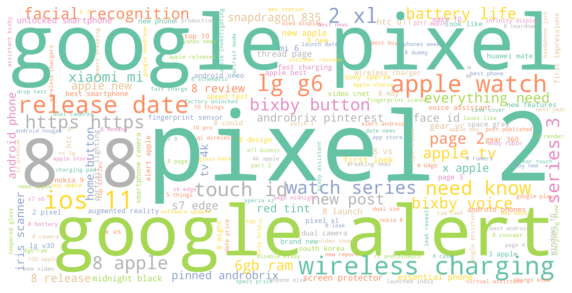

In [93]:
# visualization for titles
# Create the wordcloud object
wordcloud = WordCloud(width = 400, height = 200,margin = 0,
                      background_color = 'white', colormap = 'Set2',max_words=200000, scale = 10).generate_from_frequencies(dct_bigram_clean)
plt.figure(figsize = (10,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("wordcloud_title_bigram_clean.png")
plt.show()


From the wordcloud of bigram for titles, we know that product names as iphone 8, galaxy s8, samsung galaxy, iphone x, mentioned very frequently. Other features like wireless charging, battery life, facial recognition, are brought up along with these products. 

After filtering out the product names for the target product that we would like to see, some other competitors' name pop up as google pixel. Apart from that, we have more clear visualization on what features are brought up by people.

However, for more analysis on the features for each product, we need to look into the actual text of the post itself. This will be done by using the ```Topic extraction with Latent Dirichlet Allocation``` and ```Clustering text documents using k-means```. See the other notebook for these two.

In [94]:
# end of this notebook